<a href="https://colab.research.google.com/github/lsrodri/KneeOsteoarthritis/blob/main/image_preprocessing_and_splitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# delete any existing folders recursively

!rm -rf */

In [2]:
# Download rar files from urls and decompress them to the local folder downloaded_data

!apt install rar unrar -qq
!mkdir downloaded_data
!wget --no-verbose -P ./downloaded_data/ https://data.mendeley.com/public-files/datasets/t9ndx37v5h/files/fc9452db-a1a3-4cbc-a862-fefa59e1989b/file_downloaded
!wget --no-verbose -P ./downloaded_data/ https://data.mendeley.com/public-files/datasets/t9ndx37v5h/files/360517f1-54df-4d21-8077-1f4d0271dda3/file_downloaded
!unrar x -inul ./downloaded_data/file_downloaded ./downloaded_data/
!unrar x -inul ./downloaded_data/file_downloaded.1 ./downloaded_data/

rar is already the newest version (2:6.23-1~22.04.1).
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
2025-05-23 15:58:44 URL:https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/a18efd2c-7e27-494e-afe8-763a4bdb46d1 [60952212/60952212] -> "./downloaded_data/file_downloaded" [1]
2025-05-23 15:59:04 URL:https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/ce267433-322b-48be-8f3f-c0e1a0dfd63a [60950510/60950510] -> "./downloaded_data/file_downloaded.1" [1]


In [3]:
import os

medical_expert_i_path = 'downloaded_data/MedicalExpert-I'
medical_expert_ii_path = 'downloaded_data/MedicalExpert-II'

count_medical_expert_i = 0
for root, _, files in os.walk(medical_expert_i_path):
    count_medical_expert_i += len(files)

count_medical_expert_ii = 0
for root, _, files in os.walk(medical_expert_ii_path):
    count_medical_expert_ii += len(files)

print(f"Number of files in {medical_expert_i_path}: {count_medical_expert_i}")
print(f"Number of files in {medical_expert_ii_path}: {count_medical_expert_ii}")

Number of files in downloaded_data/MedicalExpert-I: 1650
Number of files in downloaded_data/MedicalExpert-II: 1650


In [4]:
import os
import shutil

source_dirs = ['downloaded_data/MedicalExpert-I', 'downloaded_data/MedicalExpert-II']
destination_dir = 'downloaded_data/merged_data'

os.makedirs(destination_dir, exist_ok=True)

for source_dir in source_dirs:
    for root, dirs, files in os.walk(source_dir):
        # Create corresponding subdirectories in the destination
        relative_path = os.path.relpath(root, source_dir)
        destination_subdir = os.path.join(destination_dir, relative_path)
        os.makedirs(destination_subdir, exist_ok=True)

        # Copy files, handling potential conflicts by renaming
        for file in files:
            source_file = os.path.join(root, file)
            destination_file = os.path.join(destination_subdir, file)

            if os.path.exists(destination_file):
                # If it exists, rename the file before copying
                base, ext = os.path.splitext(file)
                count = 1
                new_file = f"{base}_{count}{ext}"
                new_destination_file = os.path.join(destination_subdir, new_file)
                while os.path.exists(new_destination_file):
                    count += 1
                    new_file = f"{base}_{count}{ext}"
                    new_destination_file = os.path.join(destination_subdir, new_file)
                shutil.copy2(source_file, new_destination_file)
            else:
                # If it doesn't exist, copy the file directly
                shutil.copy2(source_file, destination_file)

print(f"Merged data into: {destination_dir}")

Merged data into: downloaded_data/merged_data


In [5]:
folder_counts = {}
for root, dirs, files in os.walk(destination_dir):
    relative_path = os.path.relpath(root, destination_dir)
    folder_counts[relative_path] = len(files)

for folder, count in folder_counts.items():
    print(f"Folder: {folder}, File Count: {count}")

# show total count
total_count = sum(folder_counts.values())
print(f"Total File Count: {total_count}")

Folder: ., File Count: 0
Folder: 1Doubtful, File Count: 965
Folder: 0Normal, File Count: 1017
Folder: 4Severe, File Count: 412
Folder: 2Mild, File Count: 464
Folder: 3Moderate, File Count: 442
Total File Count: 3300


In [6]:
!pip install imagehash

In [7]:
import imagehash
from PIL import Image
import os
import shutil
from collections import defaultdict

image_hashes = defaultdict(list)
merged_data_dir = 'downloaded_data/merged_data'
duplicates_found = 0

print("Calculating image hashes...")
for root, _, files in os.walk(merged_data_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(root, file)
            try:
                with Image.open(image_path) as img:
                    image_hash = imagehash.phash(img)
                    image_hashes[image_hash].append(image_path)
            except Exception as e:
                print(f"Could not process image {image_path} for hashing: {e}")

print("Identifying and removing duplicates...")
for image_hash, file_paths in image_hashes.items():
    if len(file_paths) > 1:
        duplicates_found += len(file_paths) - 1
        # Keep the first file and delete the rest
        files_to_delete = file_paths[1:]
        for file_path in files_to_delete:
            try:
                os.remove(file_path)
            except OSError as e:
                print(f"Error deleting file {file_path}: {e}")

print(f"\nTotal number of duplicate images found: {duplicates_found}")


Calculating image hashes...
Identifying and removing duplicates...

Total number of duplicate images found: 1758


In [8]:
image_dimensions = defaultdict(lambda: defaultdict(int))

data_dir = "downloaded_data/merged_data"

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(root, file)
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    dimension = f"{width}x{height}"
                    relative_folder = os.path.relpath(root, data_dir)
                    image_dimensions[relative_folder][dimension] += 1
            except Exception as e:
                print(f"Could not open image {image_path} to get dimensions: {e}")

print("\nImage Dimensions Summary:")
for folder, dims in image_dimensions.items():
    print(f"Folder: {folder}")
    for dim, count in dims.items():
        print(f"  Dimension: {dim}, Count: {count}")


Image Dimensions Summary:
Folder: 1Doubtful
  Dimension: 640x161, Count: 39
  Dimension: 300x162, Count: 435
Folder: 0Normal
  Dimension: 300x162, Count: 408
  Dimension: 640x161, Count: 49
Folder: 4Severe
  Dimension: 300x162, Count: 205
Folder: 2Mild
  Dimension: 300x162, Count: 181
  Dimension: 640x161, Count: 33
Folder: 3Moderate
  Dimension: 300x162, Count: 161
  Dimension: 640x161, Count: 31


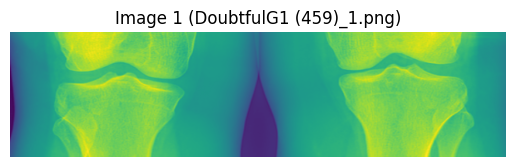

Displayed image with dimensions 640x161: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (459)_1.png


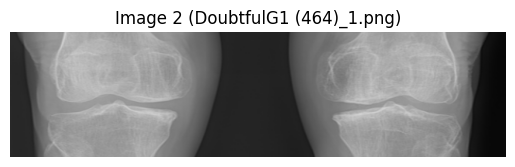

Displayed image with dimensions 640x161: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (464)_1.png


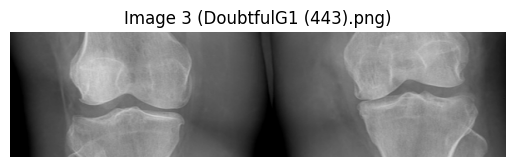

Displayed image with dimensions 640x161: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (443).png


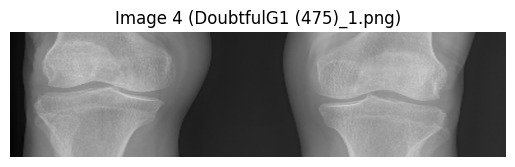

Displayed image with dimensions 640x161: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (475)_1.png


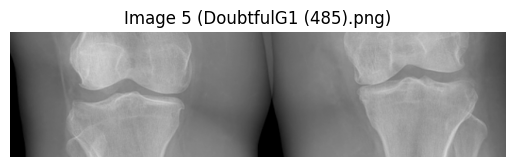

Displayed image with dimensions 640x161: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (485).png


In [9]:
# render examples of images that have wider dimensions
# these images need splitting as they contain both knees
import matplotlib.pyplot as plt

data_dir = "downloaded_data/merged_data"

count = 0
for root, _, files in os.walk(data_dir):
    for file in files:
        if count >= 5:
            break
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(root, file)
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    if width == 640 and height == 161:
                        plt.imshow(img)
                        plt.title(f"Image {count+1} ({os.path.basename(image_path)})")
                        plt.axis('off')
                        plt.show()
                        print(f"Displayed image with dimensions 640x161: {image_path}")
                        count += 1
            except Exception as e:
                print(f"Could not open image {image_path} to display: {e}")
    if count >= 5:
        break

In [10]:
# inside each folder, replace 640x161 images with the two 300x161 images

import os
import shutil
from PIL import Image
import numpy as np
from collections import defaultdict

def find_optimal_crop_point(image_array, crop_width):
    """
    Finds the optimal starting x-coordinate for cropping an image.
    Optimal point is determined by maximizing the sum of pixel intensities
    within the crop window.

    Args:
        image_array (np.ndarray): The image as a NumPy array.
                                  Assumes grayscale or converts to grayscale.
        crop_width (int): The desired width of the cropped image.

    Returns:
        int: The optimal starting x-coordinate for the crop.
    """
    # Convert to grayscale if not already (assumes intensity is important)
    if len(image_array.shape) > 2:
        # Simple average of color channels
        gray_image = np.mean(image_array, axis=2).astype(np.uint8)
    else:
        gray_image = image_array

    height, width = gray_image.shape

    if crop_width > width:
        print("Warning: Crop width is larger than image width.")
        return 0 # Cannot crop, return start of the image

    max_intensity_sum = -1
    optimal_start_x = 0

    # Iterate through all possible starting x-coordinates
    for start_x in range(width - crop_width + 1):
        end_x = start_x + crop_width
        # Calculate the sum of pixel intensities in the current window
        current_intensity_sum = np.sum(gray_image[:, start_x:end_x])

        if current_intensity_sum > max_intensity_sum:
            max_intensity_sum = current_intensity_sum
            optimal_start_x = start_x

    return optimal_start_x

def crop_image_optimal(image_path, crop_width=300, target_height=161):
    """
    Opens an image, finds the optimal crop point based on intensity,
    and crops two images of the specified size.

    Args:
        image_path (str): Path to the image file.
        crop_width (int): The desired width of the cropped images.
        target_height (int): The desired height of the cropped images.

    Returns:
        tuple: A tuple containing the two cropped PIL Image objects,
               or (None, None) if the image cannot be processed or
               is not the correct size (640x161).
    """
    try:
        img = Image.open(image_path)
        original_width, original_height = img.size

        if original_width != 640 or original_height != 161:
            return None, None

        if target_height != original_height:
             print(f"Warning: Target height ({target_height}) does not match original height ({original_height}). Using original height for cropping.")


        # Convert image to array for processing
        img_array = np.array(img)

        # Find optimal start from the left
        optimal_start_left = find_optimal_crop_point(img_array, crop_width)

        # Find optimal start from the right by reversing the image and finding the optimal start
        img_array_reversed = np.fliplr(img_array)
        optimal_start_right_reversed = find_optimal_crop_point(img_array_reversed, crop_width)
        optimal_start_right = original_width - optimal_start_right_reversed - crop_width

        # Ensure valid crop boundaries
        crop1_left = max(0, optimal_start_left)
        crop1_right = min(original_width, crop1_left + crop_width)
        if crop1_right - crop1_left < crop_width:
             crop1_left = crop1_right - crop_width

        crop2_left = max(0, optimal_start_right)
        crop2_right = min(original_width, crop2_left + crop_width)
        if crop2_right - crop2_left < crop_width:
             crop2_left = crop2_right - crop_width

        crop1_left = max(0, crop1_left)
        crop2_left = max(0, crop2_left)

        crop1_right = min(original_width, crop1_left + crop_width)
        crop2_right = min(original_width, crop2_left + crop_width)

        crop1_right = crop1_left + crop_width
        crop2_right = crop2_left + crop_width

        # Define the bounding boxes for the two crops
        box1 = (crop1_left, 0, crop1_right, target_height)
        box2 = (crop2_left, 0, crop2_right, target_height)

        # Perform the crops
        cropped_img1 = img.crop(box1)
        cropped_img2 = img.crop(box2)

        return cropped_img1, cropped_img2

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None


# Define the root directory containing the merged data
merged_data_dir = 'downloaded_data/merged_data'

print(f"\nProcessing images in: {merged_data_dir}")
# Walk through all subdirectories in the merged data directory
for subdir_root, _, files in os.walk(merged_data_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(subdir_root, file)

            try:
                with Image.open(image_path) as img_check:
                    width, height = img_check.size

                    # Check if the image has the target dimension (640x161)
                    if width == 640 and height == 161:
                        print(f"Processing 640x161 image: {image_path}")

                        # Generate the two cropped images
                        cropped_img1, cropped_img2 = crop_image_optimal(image_path, crop_width=300, target_height=161)

                        if cropped_img1 and cropped_img2:
                            # Define new filenames for the cropped images
                            base_name, ext = os.path.splitext(file)
                            new_file_name1 = f"{base_name}_crop1{ext}"
                            new_file_name2 = f"{base_name}_crop2{ext}"

                            new_image_path1 = os.path.join(subdir_root, new_file_name1)
                            new_image_path2 = os.path.join(subdir_root, new_file_name2)

                            # Save the cropped images
                            cropped_img1.save(new_image_path1)
                            cropped_img2.save(new_image_path2)

                            print(f"  Saved: {new_image_path1}")
                            print(f"  Saved: {new_image_path2}")

                            # Remove the original 640x161 image
                            os.remove(image_path)
                            print(f"  Removed original: {image_path}")

            except Exception as e:
                print(f"Error processing or replacing image {image_path}: {e}")

print("\nFinished processing and replacing 640x161 images with 300x161 crops.")

# Re-run the dimension check to see the result
print("\nImage Dimensions Summary After Replacement:")
image_dimensions_after = defaultdict(lambda: defaultdict(int))

# Set the data_dir for the dimension check to the merged data location
data_dir = "downloaded_data/merged_data"

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(root, file)
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    dimension = f"{width}x{height}"
                    relative_folder = os.path.relpath(root, data_dir)
                    image_dimensions_after[relative_folder][dimension] += 1
            except Exception as e:
                print(f"Could not open image {image_path} to get dimensions: {e}")

for folder, dims in image_dimensions_after.items():
    print(f"Folder: {folder}")
    for dim, count in dims.items():
        print(f"  Dimension: {dim}, Count: {count}")


Processing images in: downloaded_data/merged_data
Processing 640x161 image: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (459)_1.png
  Saved: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (459)_1_crop1.png
  Saved: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (459)_1_crop2.png
  Removed original: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (459)_1.png
Processing 640x161 image: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (464)_1.png
  Saved: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (464)_1_crop1.png
  Saved: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (464)_1_crop2.png
  Removed original: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (464)_1.png
Processing 640x161 image: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (443).png
  Saved: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (443)_crop1.png
  Saved: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (443)_crop2.png
  Removed original: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (443).p

In [11]:
# upscale images (300x161 or 300x162) in downloaded_data/merged_data/ subfolders
# height gets upscaled to 224 and width widens proportionally
# then we crop them horizontally at the center to 224
# resulting images placed at a new folder in downloaded_data named 224

import os
from PIL import Image
import math

# Define input and output directories
input_base_dir = 'downloaded_data/merged_data'
output_base_dir = 'downloaded_data/224'

# Create the output base directory if it doesn't exist
os.makedirs(output_base_dir, exist_ok=True)

print(f"Processing images from: {input_base_dir}")
print(f"Saving processed images to: {output_base_dir}")

# Iterate through all subfolders in the input directory
for root, _, files in os.walk(input_base_dir):
    # Get the relative path to the current subfolder
    relative_path = os.path.relpath(root, input_base_dir)

    # Create the corresponding subfolder in the output directory
    output_subdir = os.path.join(output_base_dir, relative_path)
    os.makedirs(output_subdir, exist_ok=True)

    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(root, file)
            output_path = os.path.join(output_subdir, file)

            try:
                with Image.open(image_path) as img:
                    original_width, original_height = img.size

                    # Check if the image has one of the target dimensions
                    if (original_width == 300 and original_height == 161) or (original_width == 300 and original_height == 162):
                        print(f"Processing image: {image_path}")

                        # Calculate the new width while maintaining aspect ratio
                        # Target height is 224
                        new_height = 224
                        aspect_ratio = original_width / original_height
                        new_width = math.ceil(new_height * aspect_ratio)

                        # Ensure new width is at least 224 for cropping
                        if new_width < 224:
                            print(f"  Warning: Calculated new width ({new_width}) is less than the target crop width (224). Setting new width to 224.")
                            new_width = 224

                        # Resize the image to the new dimensions
                        # Use LANCZOS filter for high-quality downsampling/upsampling
                        resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

                        # Calculate crop box for center horizontal crop to 224 width
                        left = (new_width - 224) / 2
                        top = 0
                        right = left + 224
                        bottom = new_height

                        # Ensure crop box coordinates are integers
                        crop_box = (int(left), int(top), int(right), int(bottom))

                        # Perform the crop
                        cropped_img = resized_img.crop(crop_box)

                        # Save the processed image
                        cropped_img.save(output_path)
                        print(f"  Processed and saved to: {output_path} (dimensions: {cropped_img.size[0]}x{cropped_img.size[1]})")

            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

print("\nFinished processing images and saving to", output_base_dir)

# Optional: Verify the number of files in the new directory structure
print("\nVerifying file counts in the new directory:")
for root, _, files in os.walk(output_base_dir):
    relative_path = os.path.relpath(root, output_base_dir)
    print(f"  Folder: {relative_path}, File Count: {len(files)}")

Processing images from: downloaded_data/merged_data
Saving processed images to: downloaded_data/224
Processing image: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (248)_1.png
  Processed and saved to: downloaded_data/224/1Doubtful/DoubtfulG1 (248)_1.png (dimensions: 224x224)
Processing image: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (11)_1.png
  Processed and saved to: downloaded_data/224/1Doubtful/DoubtfulG1 (11)_1.png (dimensions: 224x224)
Processing image: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (231)_1.png
  Processed and saved to: downloaded_data/224/1Doubtful/DoubtfulG1 (231)_1.png (dimensions: 224x224)
Processing image: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (405)_1.png
  Processed and saved to: downloaded_data/224/1Doubtful/DoubtfulG1 (405)_1.png (dimensions: 224x224)
Processing image: downloaded_data/merged_data/1Doubtful/DoubtfulG1 (116)_1.png
  Processed and saved to: downloaded_data/224/1Doubtful/DoubtfulG1 (116)_1.png (dimensions: 224x224)
Pr

In [12]:
# Number of images in the 224 folder

folder_224_path = 'downloaded_data/224'

count_224_images = 0
for root, _, files in os.walk(folder_224_path):
    # Count only image files
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            count_224_images += 1

print(f"Number of images in the '224' folder: {count_224_images}")

Number of images in the '224' folder: 1694


In [14]:
import os
from PIL import Image
import numpy as np
import cv2 # We'll use OpenCV for CLAHE
from collections import defaultdict

def process_image_with_histogram_norm(image_path, normalization_type='minmax', hist_norm_method=None):
    """
    Processes an image by handling color space and bit depth,
    applying optional histogram normalization, and then performing min-max scaling.

    Args:
        image_path (str): Path to the image file.
        normalization_type (str): 'minmax' for min-max scaling.
                                  (Currently only 'minmax' is implemented after hist norm)
        hist_norm_method (str): None, 'equalization' for standard histogram equalization,
                                'clahe' for Contrast Limited Adaptive Histogram Equalization.

    Returns:
        np.ndarray: Normalized image as a NumPy array (float32), or None if processing fails.
    """
    try:
        with Image.open(image_path) as img:
            # 1. Handle Color Spaces and Bit Depth
            if img.mode == 'RGB':
                # Convert RGB to grayscale (8-bit)
                img_gray = img.convert('L')
                img_array = np.array(img_gray)
            elif img.mode == 'L;16': # PIL uses 'L;16' for 16-bit grayscale
                # Convert 16-bit grayscale to NumPy array (will be uint16)
                img_array = np.array(img)
            elif img.mode == 'L': # 8-bit grayscale
                img_array = np.array(img)
            else:
                print(f"Skipping unsupported image mode: {img.mode} for {image_path}")
                return None

            # 2. Apply Histogram Normalization (if requested)
            processed_img_array = img_array.copy() # Work on a copy to avoid modifying original array

            if hist_norm_method == 'equalization':
                # Standard Histogram Equalization (best on 8-bit)
                # If input was 16-bit, equalize on 16-bit values directly
                if processed_img_array.dtype == np.uint16:
                    # Downscale 16-bit to 8-bit for equalization
                    processed_img_array_8bit = cv2.convertScaleAbs(processed_img_array, alpha=(255.0/65535.0))
                    equalized_img_array_8bit = cv2.equalizeHist(processed_img_array_8bit)
                    # We'll normalize this 8-bit equalized image later
                    processed_img_array = equalized_img_array_8bit
                else: # Assume 8-bit
                    processed_img_array = cv2.equalizeHist(processed_img_array)
                print(f"  Applied Histogram Equalization to {os.path.basename(image_path)}")

            elif hist_norm_method == 'clahe':
                # Contrast Limited Adaptive Histogram Equalization
                # Create a CLAHE object (adjust clipLimit and tileGridSize as needed)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                # CLAHE works on 8-bit or 16-bit
                processed_img_array = clahe.apply(processed_img_array)
                print(f"  Applied CLAHE to {os.path.basename(image_path)}")

            # 3. Data Type Conversion and Initial Scaling (if needed) before final normalization
            # Convert to float32 and scale if it was 16-bit and no 8-bit conversion was done for equalization
            if processed_img_array.dtype == np.uint16:
                 processed_img_array = processed_img_array.astype(np.float32) / 65535.0
            elif processed_img_array.dtype == np.uint8:
                 processed_img_array = processed_img_array.astype(np.float32) / 255.0


            # 4. Final Normalization (Min-Max scaling to 0-1 range, per image)
            if normalization_type == 'minmax':
                min_val = np.min(processed_img_array)
                max_val = np.max(processed_img_array)

                if max_val - min_val > 1e-6: # Avoid division by zero for uniform images
                    normalized_img_array = (processed_img_array - min_val) / (max_val - min_val)
                else:
                    # Handle cases where the image is uniform after processing
                    normalized_img_array = processed_img_array - min_val # Result will be all zeros
            else:
                print(f"Warning: Unsupported normalization type '{normalization_type}'. Returning data after hist norm.")
                normalized_img_array = processed_img_array


            # Now, normalized_img_array has pixel values typically between 0 and 1 (float32)
            # The range might slightly exceed 0-1 after CLAHE and subsequent min-max,
            # but it should be close.

            return normalized_img_array

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

data_dir = 'downloaded_data/224'
output_normalized_dir = 'downloaded_data/224_normalized_hist'

os.makedirs(output_normalized_dir, exist_ok=True)

# Choose your histogram normalization method: None, 'equalization', or 'clahe'
histogram_normalization_method = 'clahe'

print(f"Processing images from: {data_dir} with histogram normalization method: {histogram_normalization_method}")
print(f"Saving processed images to: {output_normalized_dir}")


for root, _, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(root, file)

            # Construct the output path, maintaining the folder structure
            relative_path = os.path.relpath(root, data_dir)
            output_subdir = os.path.join(output_normalized_dir, relative_path)
            os.makedirs(output_subdir, exist_ok=True)
            output_path = os.path.join(output_subdir, file)

            # Process the image with histogram normalization and then min-max scaling
            processed_image_array = process_image_with_histogram_norm(
                image_path,
                normalization_type='minmax',
                hist_norm_method=histogram_normalization_method
            )

            if processed_image_array is not None:
                # Ensure values are clipped to 0-1 before scaling to 0-255
                processed_image_array_clipped = np.clip(processed_image_array, 0, 1)
                processed_image_pil = Image.fromarray((processed_image_array_clipped * 255).astype(np.uint8), mode='L')

                # Save the processed image
                processed_image_pil.save(output_path)
                print(f"Processed and saved normalized image to: {output_path}")
            else:
                print(f"Failed to process image: {image_path}")

print("\nFinished processing images with histogram normalization.")

# Verify the number of files in the new directory structure
print("\nVerifying file counts in the new directory:")
for root, _, files in os.walk(output_normalized_dir):
    relative_path = os.path.relpath(root, output_normalized_dir)
    print(f"  Folder: {relative_path}, File Count: {len(files)}")

Processing images from: downloaded_data/224 with histogram normalization method: clahe
Saving processed images to: downloaded_data/224_normalized_hist
  Applied CLAHE to DoubtfulG1 (248)_1.png
Processed and saved normalized image to: downloaded_data/224_normalized_hist/1Doubtful/DoubtfulG1 (248)_1.png
  Applied CLAHE to DoubtfulG1 (11)_1.png
Processed and saved normalized image to: downloaded_data/224_normalized_hist/1Doubtful/DoubtfulG1 (11)_1.png
  Applied CLAHE to DoubtfulG1 (231)_1.png
Processed and saved normalized image to: downloaded_data/224_normalized_hist/1Doubtful/DoubtfulG1 (231)_1.png
  Applied CLAHE to DoubtfulG1 (405)_1.png
Processed and saved normalized image to: downloaded_data/224_normalized_hist/1Doubtful/DoubtfulG1 (405)_1.png
  Applied CLAHE to DoubtfulG1 (116)_1.png
Processed and saved normalized image to: downloaded_data/224_normalized_hist/1Doubtful/DoubtfulG1 (116)_1.png
  Applied CLAHE to DoubtfulG1 (104).png
Processed and saved normalized image to: downloaded

In [15]:
print("\nSummarizing Image Metadata for downloaded_data/224_normalized_hist:")

normalized_hist_dir = 'downloaded_data/224_normalized_hist'

# Dictionaries to store metadata counts
color_space_counts = defaultdict(int)
bit_depth_counts = defaultdict(int)
dimension_counts = defaultdict(int)

total_images_analyzed = 0
failed_to_open_count = 0

for root, _, files in os.walk(normalized_hist_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(root, file)

            try:
                with Image.open(image_path) as img:
                    total_images_analyzed += 1

                    # Get Color Space (PIL mode)
                    color_space_counts[img.mode] += 1

                    # Get Bit Depth (This is less straightforward with PIL modes like 'L')
                    # 'L' is typically 8-bit. 'L;16' is 16-bit.
                    # After processing and saving as 'L' (as done in the preceding code),
                    # they should all be 8-bit.
                    if img.mode == 'L':
                        bit_depth_counts['8-bit'] += 1
                    elif img.mode == 'L;16':
                         bit_depth_counts['16-bit'] += 1
                    # Add other modes if necessary, but based on the processing code, 'L' is expected.


                    # Get Dimensions
                    width, height = img.size
                    dimension = f"{width}x{height}"
                    dimension_counts[dimension] += 1

            except Exception as e:
                failed_to_open_count += 1
                print(f"Could not open image {image_path} for metadata analysis: {e}")

print(f"\nTotal images found in {normalized_hist_dir}: {total_images_analyzed + failed_to_open_count}")
print(f"Successfully analyzed: {total_images_analyzed}")
print(f"Failed to analyze: {failed_to_open_count}")

print("\nColor Space Summary:")
if color_space_counts:
    for mode, count in color_space_counts.items():
        print(f"  Mode '{mode}': {count} images")
else:
    print("  No images analyzed.")

print("\nBit Depth Summary:")
if bit_depth_counts:
    for depth, count in bit_depth_counts.items():
        print(f"  {depth}: {count} images")
else:
     print("  No images analyzed.")


print("\nDimension Summary:")
if dimension_counts:
    sorted_dimensions = sorted(dimension_counts.items())
    for dim, count in sorted_dimensions:
        print(f"  Dimension '{dim}': {count} images")
else:
    print("  No images analyzed.")

print("\nEnd of Metadata Summary.")


Summarizing Image Metadata for downloaded_data/224_normalized_hist:

Total images found in downloaded_data/224_normalized_hist: 1632
Successfully analyzed: 1632
Failed to analyze: 0

Color Space Summary:
  Mode 'L': 1632 images

Bit Depth Summary:
  8-bit: 1632 images

Dimension Summary:
  Dimension '224x224': 1632 images

End of Metadata Summary.


In [16]:
import os
import shutil
import random

processed_data_dir = 'processed_data'
os.makedirs(processed_data_dir, exist_ok=True)

# Define the source directory containing the normalized images
source_data_dir = 'downloaded_data/224_normalized_hist'

# Define the target directories for the splits within processed_data
train_dir = os.path.join(processed_data_dir, 'train')
validation_dir = os.path.join(processed_data_dir, 'validation')
test_dir = os.path.join(processed_data_dir, 'test')

# Create the split directories within processed_data
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print(f"Splitting data from: {source_data_dir} into {processed_data_dir}/train, {processed_data_dir}/validation, and {processed_data_dir}/test")

# Iterate through each subfolder in the source data directory
for subdir in os.listdir(source_data_dir):
    subdir_path = os.path.join(source_data_dir, subdir)

    # Only process directories
    if os.path.isdir(subdir_path):
        # Get a list of all files in the current subfolder
        files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]

        # Shuffle the list of files randomly
        random.shuffle(files)

        total_files = len(files)
        # Calculate the number of files for each split (60% train, 20% validation, 20% test)
        train_count = int(0.6 * total_files)
        validation_count = int(0.2 * total_files)
        test_count = total_files - train_count - validation_count # Ensure all files are included

        # Slice the shuffled list to get the files for each split
        train_files = files[:train_count]
        validation_files = files[train_count:train_count + validation_count]
        test_files = files[train_count + validation_count:]

        # Create corresponding subdirectories in the train, validation, and test splits
        os.makedirs(os.path.join(train_dir, subdir), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, subdir), exist_ok=True)
        os.makedirs(os.path.join(test_dir, subdir), exist_ok=True)

        # Copy files to their respective split directories
        for f in train_files:
            shutil.copy(f, os.path.join(train_dir, subdir, os.path.basename(f)))
        for f in validation_files:
            shutil.copy(f, os.path.join(validation_dir, subdir, os.path.basename(f)))
        for f in test_files:
            shutil.copy(f, os.path.join(test_dir, subdir, os.path.basename(f)))

print("\nData split into train, validation, and test sets successfully.")

print("\nFile counts in each split:")
for split_dir in [train_dir, validation_dir, test_dir]:
    print(f"\nFiles in {split_dir}:")
    split_folder_counts = {}
    for root, _, files in os.walk(split_dir):
        relative_path = os.path.relpath(root, split_dir)
        split_folder_counts[relative_path] = len(files)

    for folder, count in split_folder_counts.items():
        print(f"  Folder: {folder}, File Count: {count}")

Splitting data from: downloaded_data/224_normalized_hist into processed_data/train, processed_data/validation, and processed_data/test

Data split into train, validation, and test sets successfully.

File counts in each split:

Files in processed_data/train:
  Folder: ., File Count: 0
  Folder: 1Doubtful, File Count: 304
  Folder: 0Normal, File Count: 283
  Folder: 4Severe, File Count: 123
  Folder: 2Mild, File Count: 139
  Folder: 3Moderate, File Count: 129

Files in processed_data/validation:
  Folder: ., File Count: 0
  Folder: 1Doubtful, File Count: 101
  Folder: 0Normal, File Count: 94
  Folder: 4Severe, File Count: 41
  Folder: 2Mild, File Count: 46
  Folder: 3Moderate, File Count: 43

Files in processed_data/test:
  Folder: ., File Count: 0
  Folder: 1Doubtful, File Count: 102
  Folder: 0Normal, File Count: 95
  Folder: 4Severe, File Count: 41
  Folder: 2Mild, File Count: 48
  Folder: 3Moderate, File Count: 43


In [17]:
!zip -r processed_data.zip processed_data

updating: processed_data/ (stored 0%)
updating: processed_data/test/ (stored 0%)
updating: processed_data/test/1Doubtful/ (stored 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (146)_1.png (stored 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (316).png (stored 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (387).png (deflated 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (413)_1.png (stored 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (210).png (stored 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (402).png (stored 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (251).png (deflated 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (396)_1.png (stored 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (199)_1.png (stored 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (404).png (stored 0%)
updating: processed_data/test/1Doubtful/DoubtfulG1 (209)_1.png (stored 0%)
updating: processed_data/test/1Doubtful/DoubtfulG